In [51]:
!pip install cartopy

In [52]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
colors = ["#5F0F40","#3D5A80","#6A994E","#E76F51","#006D77","#FFB703","#2C699A","#BC4749","#F77F00","#D1495B","#386641"]

In [53]:
df = pd.read_csv("jma 3.csv")
df.head()

,index,Record type identifier,Year,Month,Day,Hour,Minute,Second,Second error,Latitude (degrees),...,Hypocenter determination flag,time,time_std,magnitude,longitude,latitude,longitude_std,latitude_std,x_utm,y_utm
0,2,JMA,1919,1,4,18,20,25.88,6.3,41,...,K,-1.609166e+09,6.3,5.2,144.503167,41.703333,0.883333,0.473333,791793.764897,4.622020e+06
1,5,JMA,1919,1,11,1,59,50.21,8.0,35,...,K,-1.608620e+09,8.0,4.0,140.341833,35.262500,0.598333,0.443333,440434.936341,3.901597e+06
2,6,JMA,1919,1,12,22,20,47.24,16.6,35,...,K,-1.608461e+09,16.6,5.1,137.888833,35.372833,0.566667,0.608333,217649.150338,3.918079e+06
3,7,JMA,1919,1,23,0,44,35.02,14.1,29,...,S,-1.607588e+09,14.1,4.6,142.492500,29.215500,0.392833,0.391667,645377.203408,3.232027e+06
4,8,JMA,1919,1,23,4,28,5.57,5.1,36,...,K,-1.607575e+09,5.1,3.7,140.822500,36.635333,1.055000,0.478333,484433.561984,4.053680e+06


In [54]:
df['time'] = pd.to_datetime(df['time'], unit='s')
df['date'] = df['time'].dt.date
df.sort_values('time', inplace=True)
df = df[['Year','date','time','magnitude','depth','longitude','latitude','x_utm','y_utm']].copy()
df

,Year,date,time,magnitude,depth,longitude,latitude,x_utm,y_utm
0,1919,1919-01-04,1919-01-04 09:20:26.000000000,5.2,15.00,144.503167,41.703333,791793.764897,4.622020e+06
1,1919,1919-01-10,1919-01-10 16:59:50.000000000,4.0,39.00,140.341833,35.262500,440434.936341,3.901597e+06
2,1919,1919-01-12,1919-01-12 13:20:47.000000000,5.1,36.00,137.888833,35.372833,217649.150338,3.918079e+06
3,1919,1919-01-22,1919-01-22 15:44:35.000000000,4.6,129.00,142.492500,29.215500,645377.203408,3.232027e+06
4,1919,1919-01-22,1919-01-22 19:28:06.000000000,3.7,90.00,140.822500,36.635333,484433.561984,4.053680e+06
...,...,...,...,...,...,...,...,...,...
907122,2023,2023-03-31,2023-03-31 13:09:19.000000000,2.0,59.85,140.192000,34.751833,426347.602765,3.845064e+06
907123,2023,2023-03-31,2023-03-31 14:17:54.000000000,2.3,64.30,141.397500,38.254667,535080.741120,4.233392e+06
907124,2023,2023-03-31,2023-03-31 14:43:02.000000000,2.3,40.31,141.714833,37.669333,563344.075740,4.168614e+06
907125,2023,2023-03-31,2023-03-31 14:50:08.279999018,3.7,550.00,146.318667,47.670167,899525.348431,5.292616e+06


In [55]:
df.isna().sum()

,0
Year,0
date,0
time,0
magnitude,0
depth,0
longitude,0
latitude,0
x_utm,0
y_utm,0


In [56]:
df.describe()

,Year,time,magnitude,depth,longitude,latitude,x_utm,y_utm
count,907127.000000,907127,907127.00000,907127.000000,907127.000000,907127.000000,9.071270e+05,9.071270e+05
mean,2004.983815,2005-06-23 13:27:22.058494976,2.77861,51.860837,137.866258,35.242074,1.784811e+05,3.921995e+06
min,1919.000000,1919-01-04 09:20:26,2.00000,0.000000,114.778833,17.409333,-1.918999e+06,2.009620e+06
25%,1999.000000,1999-04-10 22:07:00.400000,2.20000,14.290000,132.033333,32.009667,-3.484642e+05,3.582143e+06
50%,2009.000000,2009-06-16 06:54:10,2.60000,33.200000,140.484500,36.193167,4.539792e+05,4.006060e+06
75%,2015.000000,2015-01-19 13:08:20.500000,3.10000,53.920000,142.170167,38.699167,6.028723e+05,4.283572e+06
max,2023.000000,2023-03-31 14:53:50,9.00000,698.400000,160.159833,54.969833,1.899552e+06,6.190244e+06
std,14.906033,NaN,0.74346,70.938482,6.763004,5.560584,6.584385e+05,5.914073e+05


In [57]:
df.dtypes

,0
Year,int64
date,object
time,datetime64[ns]
magnitude,float64
depth,float64
longitude,float64
latitude,float64
x_utm,float64
y_utm,float64


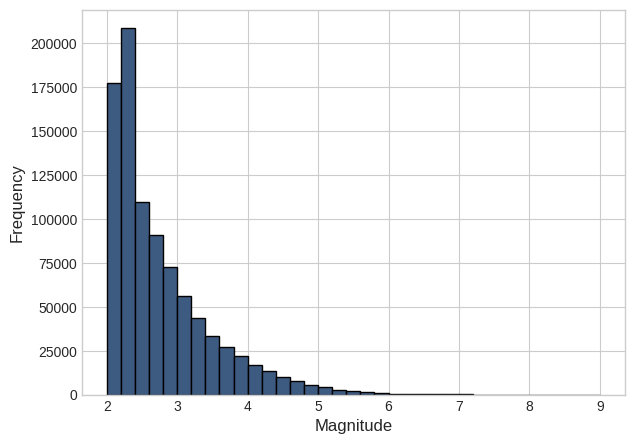

In [58]:
bins = np.arange(df['magnitude'].min(), df['magnitude'].max() + 0.2, 0.2)

plt.figure(figsize=(7, 5))
plt.hist(df['magnitude'], bins=bins, color=colors[1], edgecolor='black')
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

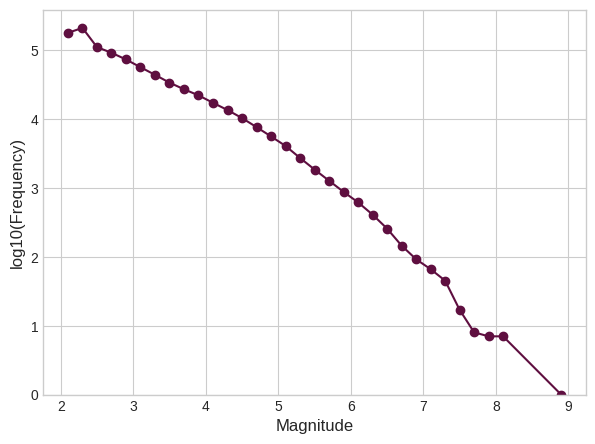

In [59]:
counts, bin_edges = np.histogram(df['magnitude'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
non_zero_indices = counts > 0

plt.figure(figsize=(7, 5))
plt.plot(bin_centers[non_zero_indices], np.log10(counts[non_zero_indices]), 'o-', color=colors[0])
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('log10(Frequency)', fontsize=12)
plt.ylim(bottom=0)
plt.show()

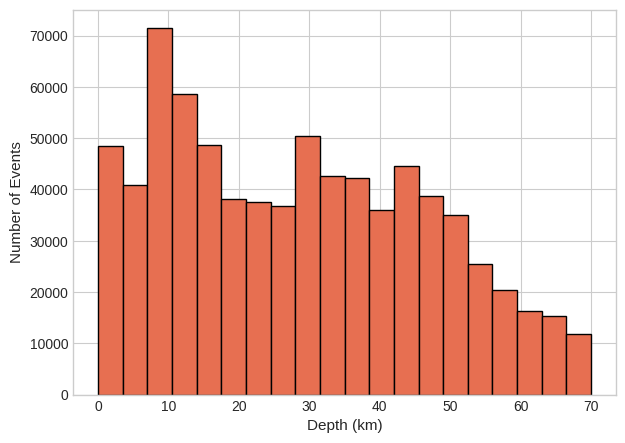

In [60]:
shallow_events = df[(df['depth'] >= 0) & (df['depth'] < 70)]

plt.figure(figsize=(7, 5))
plt.hist(shallow_events['depth'], bins=20, edgecolor='black', color=colors[3])
plt.xlabel('Depth (km)', fontsize=11)
plt.ylabel('Number of Events', fontsize=11)
plt.grid(True)
plt.show()

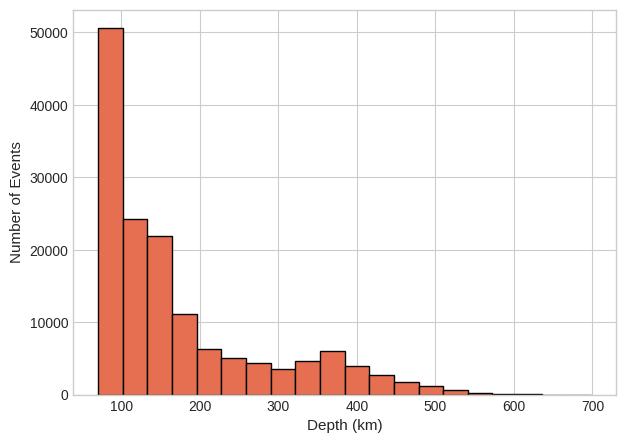

In [61]:
deep_events = df[(df['depth'] >= 70)]

plt.figure(figsize=(7, 5))
plt.hist(deep_events['depth'], bins=20, edgecolor='black', color=colors[3])
plt.xlabel('Depth (km)', fontsize=11)
plt.ylabel('Number of Events', fontsize=11)
plt.grid(True)
plt.show()

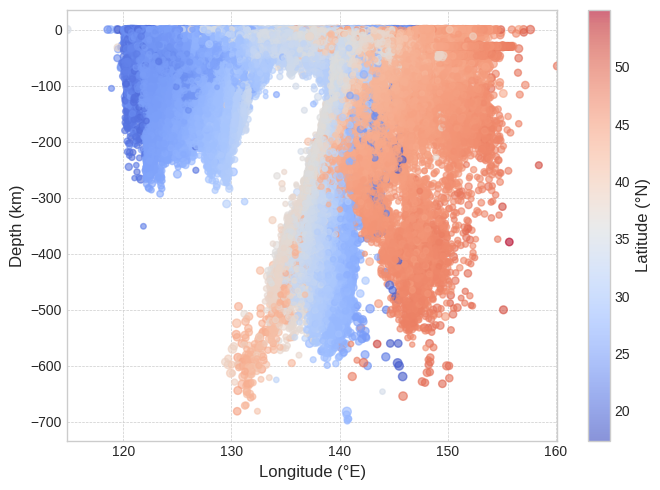

In [62]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(df['longitude'], -df['depth'], c=df['latitude'], cmap='coolwarm', s=df['magnitude'] * 5, alpha=0.6)
ax.set_xlabel('Longitude (°E)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_xlim(df['longitude'].min(), df['longitude'].max())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Latitude (°N)', fontsize=12)
plt.tight_layout()
plt.show()

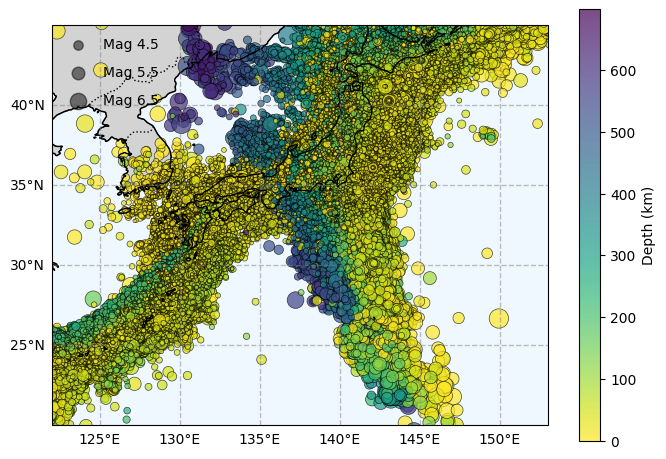

In [63]:
japan_coordinates = [122, 153, 20, 45]
plt.style.use('default')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(japan_coordinates, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

scatter = ax.scatter(df['longitude'], df['latitude'], c=df['depth'], s=(df['magnitude']**3) / 2, cmap='viridis_r', alpha=0.7, edgecolor='k', linewidth=0.5,
                     transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, shrink=0.7)
cbar.set_label('Depth (km)', fontsize=10)
for mag_val in [4.5, 5.5, 6.5]:
    ax.scatter([], [], s=(mag_val**3)/2, c='k', alpha=0.5, label=f'Mag {mag_val}')
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left')
plt.show()

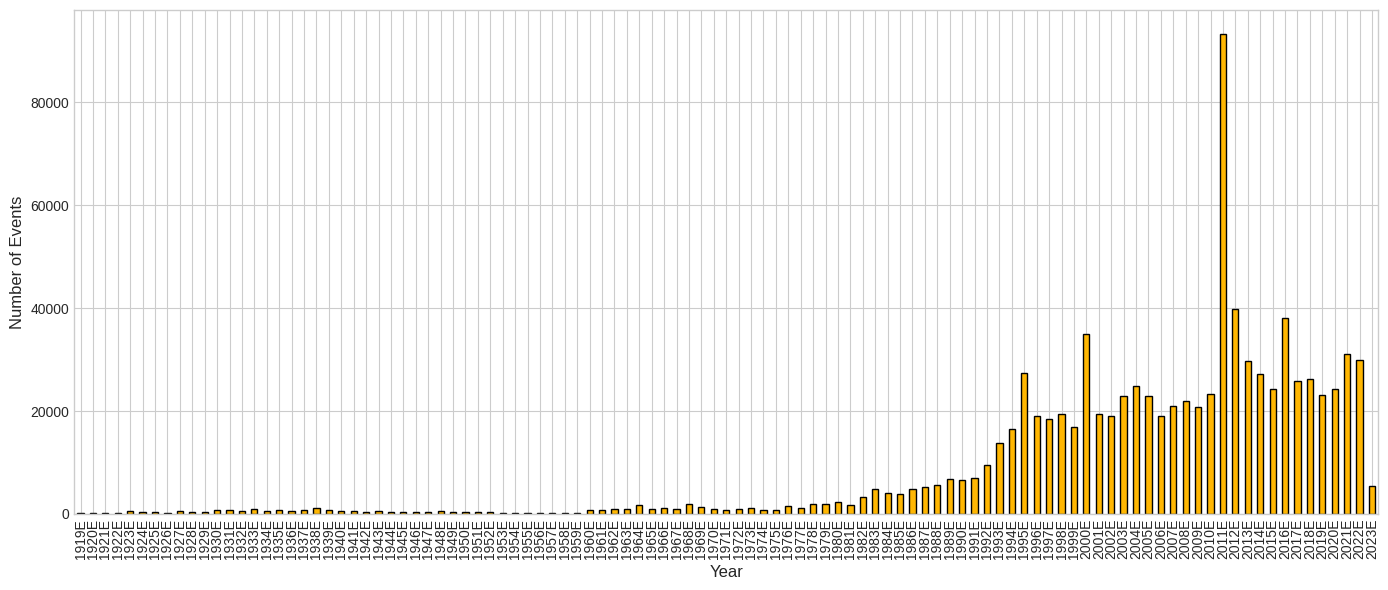

In [64]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 6))

events_per_year = df.set_index('time')['magnitude'].resample('YE').count()
events_per_year.plot(kind='bar', ax=ax, color=colors[5], edgecolor='black')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Events', fontsize=12)
ax.set_xticklabels([d.strftime('%YE') for d in events_per_year.index])
plt.tight_layout()
plt.show()

In [65]:
def fmd(mag, mbin):
	"""
	Computes the frequency-magnitude distribution of earthquakes.

	Parameters:
	- mag (array-like): Array of earthquake magnitudes.
	- mbin (float): Magnitude bin size.

	Returns:
	- dict: Dictionary containing magnitude bins, cumulative counts, and non-cumulative counts.
	"""
	mag = np.array(mag)

	mi = np.arange(min(np.round(mag/mbin)*mbin), max(np.round(mag/mbin)*mbin),mbin)

	nbm = len(mi)
	cumnbmag = np.zeros(nbm)
	nbmag = np.zeros(nbm)

	for i in range(nbm):
		cumnbmag[i] = sum((mag > mi[i]-mbin/2))

	cumnbmagtmp = np.append(cumnbmag,0)
	nbmag = abs(np.ediff1d(cumnbmagtmp))

	res = {'m':mi, 'cum':cumnbmag, 'noncum':nbmag}

	return res

In [66]:
def maxc(mag, mbin):
	"""
	Determines the magnitude of completeness (Mc) from the frequency-magnitude distribution.

	Parameters:
	- mag (array-like): Array of earthquake magnitudes.
	- mbin (float): Magnitude bin size.

	Returns:
	- float: Magnitude of completeness (Mc).
	"""
	FMD = fmd(mag, mbin)

	if len(FMD['noncum'])>0:
	# if True:

		Mc = FMD['m'][np.where(FMD['noncum']==max(FMD['noncum']))[0]][0]

	else:
		Mc = None

	return Mc

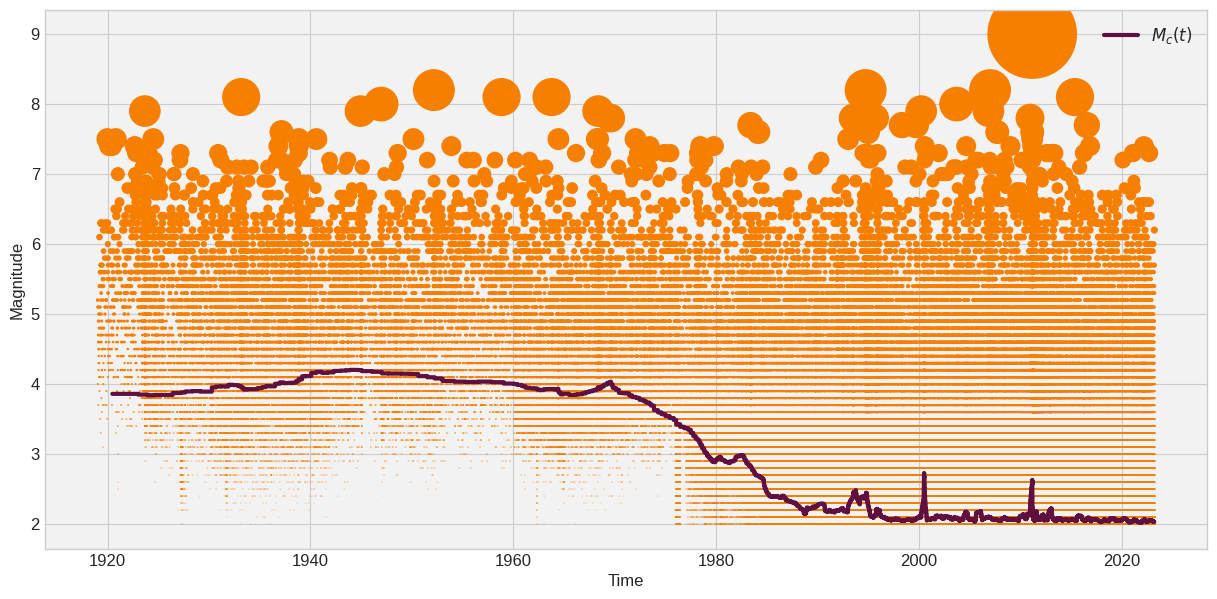

In [67]:
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(df['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = df['time']
comp_M = df['magnitude']

for i in range(nwindows):

    mid_time[i] = pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (7**df['magnitude']) * 0.0001
plt.scatter(df['time'],df['magnitude'],s=z,color=colors[8])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

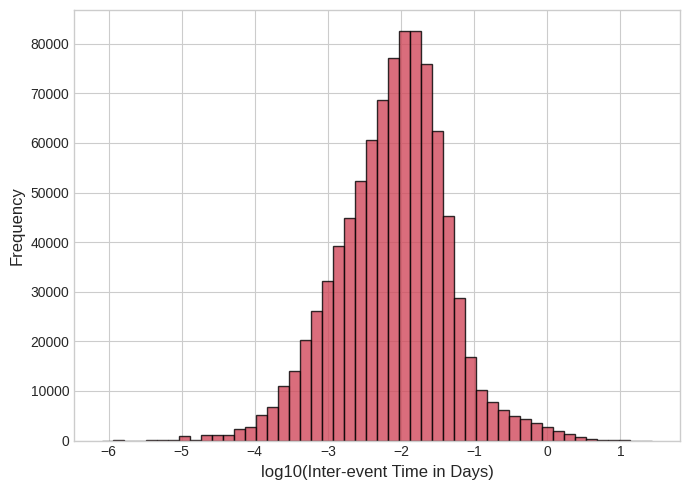

In [68]:
df_sorted = df.sort_values('time')
interevent_times = df_sorted['time'].diff().dt.total_seconds() / (3600 * 24)
interevent_times = interevent_times.dropna()
log_iets = np.log10(interevent_times[interevent_times > 0])

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(log_iets, bins=50, color=colors[9], edgecolor='black', alpha=0.8)
ax.set_xlabel('log10(Inter-event Time in Days)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()